1. EXPLORATIVE DATA ANALYSIS

IMPORTING LIBRARIES

In [1]:
# Data exploration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Text processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


DATA LOADING

In [2]:
df = pd.read_csv('edos_labelled_aggregated.csv')

DATA CLEANING

In [3]:
df = df.drop(columns=["label_category","label_vector"])
df = df.drop_duplicates()
df = df.dropna(subset=['text'])

DATA VISUALIZATION

In [4]:
df.head(10)

,rewire_id,text,label_sexist,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,train
3,sexism2022_english-13021,woman?,not sexist,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,dev
5,sexism2022_english-14998,Unlicensed day care worker reportedly tells co...,not sexist,train
6,sexism2022_english-7228,[USER] Leg day is easy. Hot girls who wear min...,sexist,train
7,sexism2022_english-4196,I don't know if you should avoid this one or e...,not sexist,train
8,sexism2022_english-872,I get a new pussy every other week or whenever...,sexist,train
9,sexism2022_english-3553,I agree with that but at the same time I know ...,sexist,dev


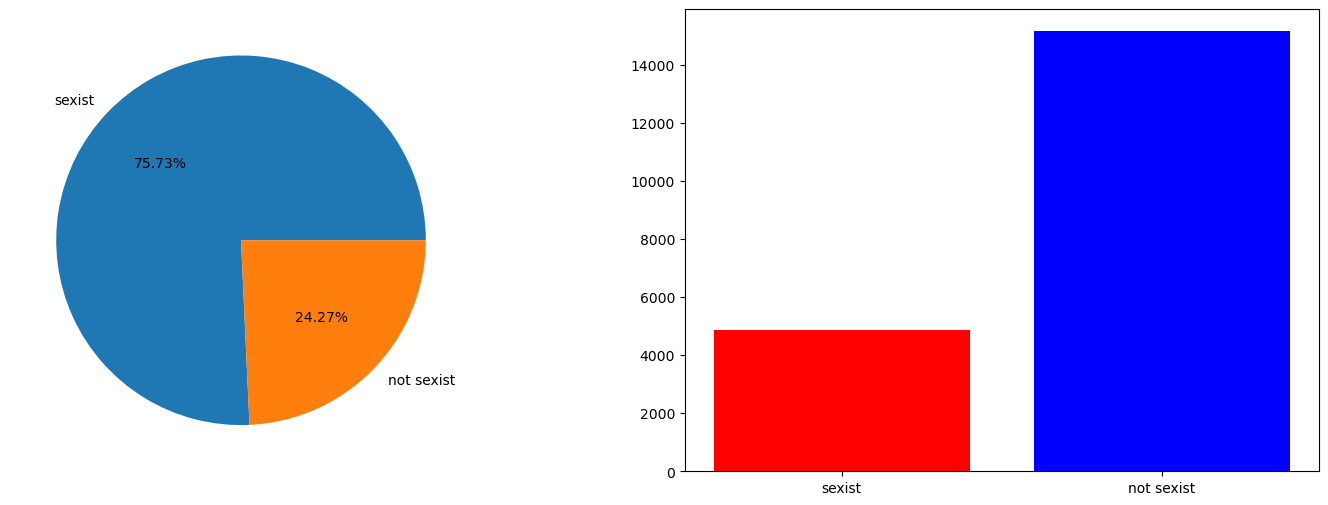

In [5]:
count = df['label_sexist'].value_counts()
labels = ["sexist", "not sexist"]
sizes = [count.get('sexist', 0), count.get('not sexist', 0)]
colors = ['red', 'blue']

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].pie(count,labels=labels, autopct='%1.2f%%')
axs[1].bar(labels, sizes, color=colors)

plt.show()

2. PRE-PROCESSING

In [6]:
# cleaning with regex

def clean_text(sentence):
    # Convertire il testo in minuscolo
    sentence = sentence.lower()
    # Rimuovere le menzioni (@username)
    sentence = re.sub(r'@\w+', '', sentence)
    # Rimuovere gli URL
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    # Rimuovere hashtag (#hashtag)
    sentence = re.sub(r'#\w+', '', sentence)
    # Rimuovere i numeri
    sentence = re.sub(r'\d+', '', sentence)
    # Rimuovere testo tra parentesi quadre o tonde
    sentence = re.sub(r'\[.*?\]|\(.*?\)', '', sentence)
    # Rimuovere caratteri di nuova linea e tabulazione
    sentence = re.sub(r'\n|\r|\t', ' ', sentence)
    # Rimuovere spazi extra
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    # Rimuovere caratteri speciali
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Rimuovere tag HTML
    sentence = re.sub(r'<.*?>', '', sentence)
    # Rimuovere indirizzi email
    sentence = re.sub(r'\S+@\S+', '', sentence)
    return sentence

# pipeline preprocessing

def tokenize(text):
    return nltk.word_tokenize(text)

def clean_tokens(tokens):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    return [token.lower() for token in tokens if token.isalnum() and token.lower() not in stop_words]

def normalize(tokens):
    return [token.lower() for token in tokens]

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem(tokens):
    stemmer = nltk.stem.PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def nlp_pipeline(text):
    tokens = tokenize(text)
    tokens = clean_tokens(tokens)
    tokens = normalize(tokens)
    tokens = lemmatize(tokens)
    tokens = stem(tokens)
    return clean_text(' '.join(tokens))



In [7]:
# nlp pipeline
df["text"] = df["text"].apply(lambda x: nlp_pipeline(x))

In [8]:
# print some information about the corpus
print("Size of the corpus:", len(list(df["text"])))
print("Size of the vocabulary:", len(set(list(df["text"]))))
print("Lexical diversity:", len(set(df["text"])) / len(df["text"]))

Size of the corpus: 20000
Size of the vocabulary: 19969
Lexical diversity: 0.99845


In [9]:
df['Nr. Tokens'] = df["text"].apply(lambda x:len(str(x).split()))

In [10]:
df.head()

,rewire_id,text,label_sexist,split,Nr. Tokens
0,sexism2022_english-9609,nigeria rape woman men rape back nsfw nigeria ...,not sexist,dev,15
1,sexism2022_english-16993,keeper,not sexist,train,1
2,sexism2022_english-13149,like metallica video poor mutil bastard say pl...,not sexist,train,13
3,sexism2022_english-13021,woman,not sexist,train,1
4,sexism2022_english-966,bet wish gun,not sexist,dev,3


3. FEATURE EXTRACTION

In [11]:
# TF-IDF

# Vettore delle feature del testo
X = list(df["text"])

# # vettore delle labels
y = list(df["label_sexist"])

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estrazione delle caratteristiche con TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)



5. MODEL DEFINITION

In [12]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

6. EVALUATION AND METRICS

In [13]:
# evaluate the model using metrics

# Predizioni sul set di test
predictions = model.predict(X_test)

# Valutazione del modello
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='sexist')
recall = recall_score(y_test, predictions, pos_label='sexist')
f1 = f1_score(y_test, predictions, pos_label='sexist')
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.828
Precision: 0.801354401805869
Recall: 0.3717277486910995
F1 Score: 0.5078683834048641
Confusion Matrix:
[[2957   88]
 [ 600  355]]
